<a href="https://colab.research.google.com/github/tavishcode/fyp/blob/master/notebooks/rescale_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Input, Activation, CuDNNGRU, GRU, Dense
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import scale, StandardScaler, RobustScaler
from collections import OrderedDict, defaultdict
from google.colab import drive
from scipy.optimize import curve_fit
drive.mount('/content/drive')
plt.rcParams['figure.figsize'] = [10, 8]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.read_csv('drive/My Drive/train_1.csv', usecols=range(201))
df.fillna(0, inplace = True)
df = df[df['Page'].str.contains('.wikipedia.org')] 
df['lang'] = df['Page'].apply(lambda s: s.split(".wikipedia.org")[0][-2:])
df = df[df['lang'] == 'en']
df['link'] = df['Page'].apply(lambda s: s.split("_en.wikipedia")[0])
df = df[~df['link'].str.contains(':')]

In [0]:
df.shape

(23369, 203)

In [0]:
ixs = np.arange(df.shape[0])

In [0]:
df2 = df.drop(['Page', 'lang', 'link'], axis=1)

### Total Requests for each content



In [0]:
sums = df2.sum(axis=1).sort_values(ascending=False)
sums = sums.values
sums = sums[np.nonzero(sums)]
probs = sums/sum(sums)

In [0]:
arr = df2.values

Text(0.5, 1.0, 'Probability Distribution')

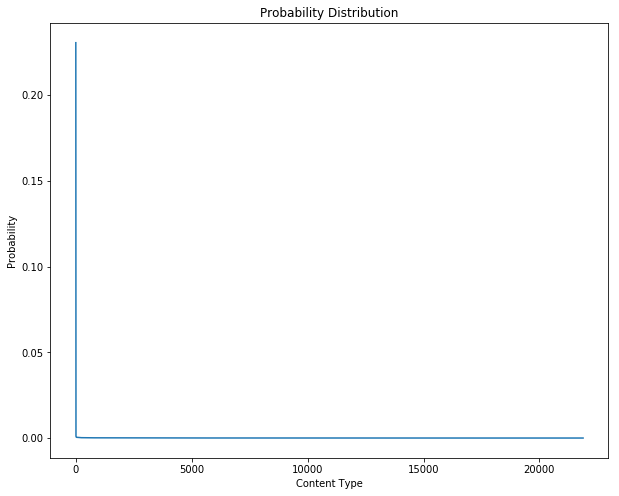

In [0]:
plt.plot(range(1, len(probs)+1), probs)
plt.xlabel('Content Type')
plt.ylabel('Probability')
plt.title('Probability Distribution')

Text(0.5, 1.0, 'log-log Probability Distribution')

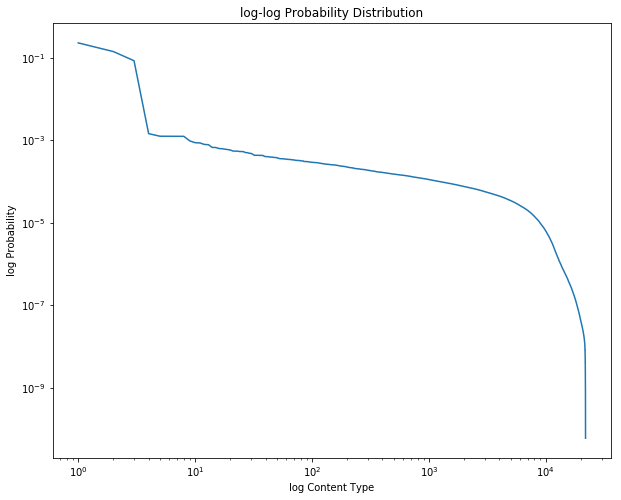

In [0]:
plt.plot(range(1, len(probs)+1), probs) #log-log plot
plt.yscale('log')
plt.xscale('log')
plt.xlabel('log Content Type')
plt.ylabel('log Probability')
plt.title('log-log Probability Distribution')

In [0]:
# fitting a zipf to the data
def zipf(x, s):
  return x**-s/sum([i**-s for i in range(1,len(probs)+1)])

x_data = [i for i in range(1,len(probs)+1)]
y_data = probs

popt, pcov = curve_fit(zipf, x_data, y_data)
popt

array([1.26018854])

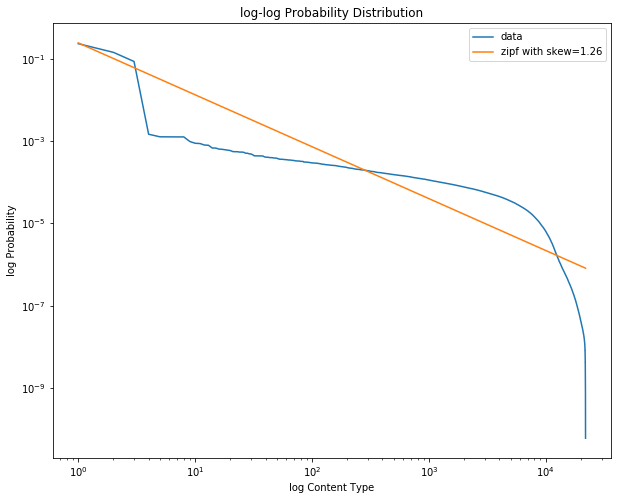

In [0]:
norm = sum([i**-popt[0] for i in range(1,len(probs)+1)])
plt.plot(range(1, len(probs)+1), probs) #log-log plot
plt.plot(x_data, [i**-popt[0]/norm for i in x_data])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('log Content Type')
plt.ylabel('log Probability')
plt.title('log-log Probability Distribution')
plt.legend(['data', 'zipf with skew=1.26'])

In [0]:
# calculate median
x = 0
for i in range(len(probs)):
  x += probs[i]
  if x >= 0.5:
    print(i+1)
    break

92


In [0]:
num_contents = 16384

### Attempt # 0 - Sorted Slice

[1.25832798]
91


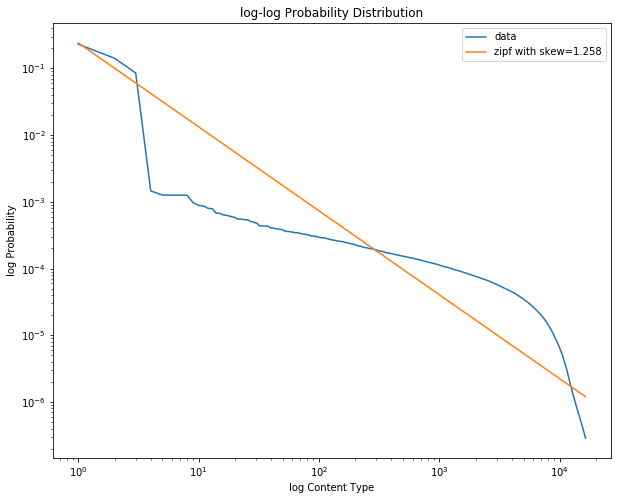

In [0]:
# using scipy curve fit
from scipy.optimize import curve_fit

def zipf(x, s):
  return x**-s/sum([i**-s for i in range(1,len(probs[:num_contents])+1)])

new_probs = probs[:num_contents]/sum(probs[:num_contents])

x_data = [i for i in range(1,len(probs[:num_contents])+1)]
y_data = new_probs

popt, pcov = curve_fit(zipf, x_data, y_data)
print(popt)
norm = sum([i**-popt[0] for i in range(1,len(probs[:num_contents])+1)])
plt.plot(range(1, num_contents+1), probs[:num_contents])
plt.plot(x_data, [i**-popt[0]/norm for i in x_data])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('log Content Type')
plt.ylabel('log Probability')
plt.title('log-log Probability Distribution')
plt.legend(['data', 'zipf with skew=1.258'])

# calculate median
x = 0
for i in range(len(new_probs)):
  x += new_probs[i]
  if x >= 0.5:
    print(i+1)
    break

### Attempt 5 - Random Sampling


In [0]:
# using scipy curve fit

from scipy.optimize import curve_fit

def zipf(x, s):
  return x**-s/sum([i**-s for i in range(1,len(r_probs)+1)])

In [0]:
df = pd.read_csv('drive/My Drive/train_1.csv', usecols=range(201))
df.fillna(0, inplace = True)
df = df[df['Page'].str.contains('.wikipedia.org')] 
df['lang'] = df['Page'].apply(lambda s: s.split(".wikipedia.org")[0][-2:])
df = df[df['lang'] == 'en']
df['link'] = df['Page'].apply(lambda s: s.split("_en.wikipedia")[0])
df = df[~df['link'].str.contains(':')]
ixs = np.arange(df2.shape[0])

In [0]:
df2.shape

(23369, 200)

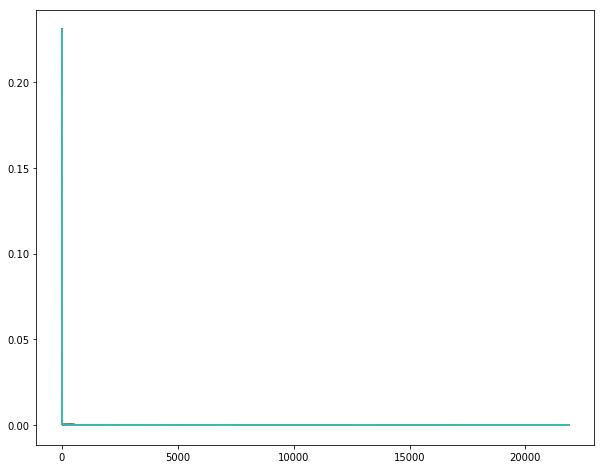

In [0]:
pairs = []
for i in range(100):
  rand = np.random.choice(ixs, 16384, replace=False)
  df2 = df.iloc[rand,:]
  df2 = df.drop(['Page', 'lang', 'link'], axis=1)
  rand_arr = df2.values
  r_sums = np.sort(np.sum(rand_arr, axis=1))[::-1]
  r_sums = r_sums[np.nonzero(r_sums)]
  r_probs = r_sums/sum(r_sums)
  r_probs = r_probs/sum(r_probs)
  x_data = [i for i in range(1,len(r_probs)+1)]
  y_data = r_probs
  popt, pcov = curve_fit(zipf, x_data, y_data)
  norm = sum([i**-popt[0] for i in range(1,len(r_probs)+1)])
  plt.plot(range(1, len(r_probs)+1), np.sort(r_probs)[::-1])
  pairs.append([rand, popt, abs(popt-1.22685873), np.sort(r_probs)[::-1], x_data, [i**-popt[0]/norm for i in range(1,len(r_probs)+1)]])

[1.26018854]


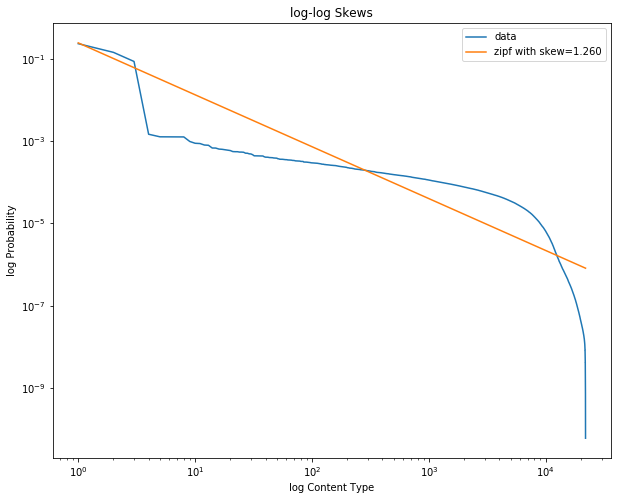

In [0]:
min_pair = min(pairs, key = lambda x: x[2])
plt.plot(min_pair[-2], min_pair[-3])
plt.plot(min_pair[-2], min_pair[-1])
print(min_pair[1])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('log Content Type')
plt.ylabel('log Probability')
plt.title('log-log Skews')
plt.legend(['data', 'zipf with skew=1.260'])

In [0]:
df_rand = df.iloc[min_pair[0],:]

In [0]:
df_rand.shape

(16384, 203)

In [0]:
df_rand["portals"] = ""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
df_rand.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-01-10,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,2016-01-16,lang,link,portals
11570,Lucifer_(TV_series)_en.wikipedia.org_desktop_a...,2182.0,2223.0,1922.0,1844.0,2008.0,2162.0,2139.0,2145.0,2922.0,...,8023.0,8662.0,7303.0,6657.0,6792.0,6754.0,6517.0,en,Lucifer_(TV_series),
77306,Final_Fantasy_XV_en.wikipedia.org_mobile-web_a...,1170.0,1163.0,1248.0,1280.0,1387.0,1152.0,1071.0,1065.0,1071.0,...,1479.0,1311.0,1493.0,1296.0,1165.0,1153.0,1216.0,en,Final_Fantasy_XV,
74655,Shraddha_Nigam_en.wikipedia.org_mobile-web_all...,483.0,412.0,407.0,449.0,472.0,426.0,523.0,635.0,672.0,...,1945.0,2017.0,2150.0,1599.0,1356.0,1216.0,1262.0,en,Shraddha_Nigam,
39449,Trump_Tower_en.wikipedia.org_all-access_all-ag...,152.0,165.0,115.0,80.0,61.0,93.0,79.0,109.0,197.0,...,157.0,126.0,102.0,111.0,100.0,159.0,156.0,en,Trump_Tower,
9007,Edmonia_Lewis_en.wikipedia.org_desktop_all-agents,51.0,91.0,48.0,88.0,52.0,69.0,81.0,109.0,65.0,...,135.0,112.0,61.0,148.0,143.0,183.0,67.0,en,Edmonia_Lewis,


In [0]:
df = pd.read_csv('drive/My Drive/train_1.csv', usecols=range(401))
df.fillna(0, inplace = True)
df = df[df['Page'].str.contains('.wikipedia.org')] 
df['lang'] = df['Page'].apply(lambda s: s.split(".wikipedia.org")[0][-2:])
df = df[df['lang'] == 'en']
df['link'] = df['Page'].apply(lambda s: s.split("_en.wikipedia")[0])
df = df[~df['link'].str.contains(':')]
df['portals'] = ""
df_rand = df.iloc[min_pair[0],:]

In [0]:
df_rand.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-07-28,2016-07-29,2016-07-30,2016-07-31,2016-08-01,2016-08-02,2016-08-03,lang,link,portals
11570,Lucifer_(TV_series)_en.wikipedia.org_desktop_a...,2182.0,2223.0,1922.0,1844.0,2008.0,2162.0,2139.0,2145.0,2922.0,...,4051.0,4220.0,3485.0,4061.0,4439.0,4019.0,3831.0,en,Lucifer_(TV_series),
77306,Final_Fantasy_XV_en.wikipedia.org_mobile-web_a...,1170.0,1163.0,1248.0,1280.0,1387.0,1152.0,1071.0,1065.0,1071.0,...,1453.0,1483.0,1565.0,1722.0,1553.0,1453.0,1571.0,en,Final_Fantasy_XV,
74655,Shraddha_Nigam_en.wikipedia.org_mobile-web_all...,483.0,412.0,407.0,449.0,472.0,426.0,523.0,635.0,672.0,...,897.0,897.0,1050.0,1401.0,1097.0,930.0,740.0,en,Shraddha_Nigam,
39449,Trump_Tower_en.wikipedia.org_all-access_all-ag...,152.0,165.0,115.0,80.0,61.0,93.0,79.0,109.0,197.0,...,258.0,304.0,248.0,249.0,291.0,308.0,349.0,en,Trump_Tower,
9007,Edmonia_Lewis_en.wikipedia.org_desktop_all-agents,51.0,91.0,48.0,88.0,52.0,69.0,81.0,109.0,65.0,...,76.0,59.0,48.0,45.0,46.0,49.0,32.0,en,Edmonia_Lewis,


In [0]:
df_rand.to_csv('drive/My Drive/rand_sample.csv')

In [0]:
df_rand.shape

(16384, 404)